# Task-Space Control of a 6 dof manipulator

## Imort all the modules needed for the simulation

In [1]:
from pickle import GLOBAL
import pinocchio as pin
import numpy as np
import sys
import os
from os.path import dirname, join, abspath
from pinocchio.visualize import MeshcatVisualizer
import time
import math
import meshcat
import matplotlib.pyplot as plt
from numpy.linalg import norm, solve
from scipy.spatial.transform import Rotation
import meshcat.transformations as tf
import meshcat.geometry as g
from numpy.linalg import inv,pinv,eig,norm,svd,det
plt.rcParams['text.usetex'] = True
%matplotlib inline
%matplotlib widget

## Meshcat functions

In [2]:
def meshcat_material(r, g, b, a):
    import meshcat

    material = meshcat.geometry.MeshPhongMaterial()
    material.color = int(r * 255) * 256 ** 2 + int(g * 255) * 256 + int(b * 255)
    material.opacity = a
    return material


## Bring the URDF model of the robot 

In [3]:
pinocchio_model_dir = '/home/unknown/Documents/PostDoc/Pinocchio_examples/Panda/Panda_description' 
mesh_dir = '/home/unknown/Documents/PostDoc/Pinocchio_examples/Panda/Panda_description/meshes' 
urdf_model_path =pinocchio_model_dir + '/urdf/panda_simple.urdf'
model, collision_model, visual_model = pin.buildModelsFromUrdf(urdf_model_path, mesh_dir)
# Choose of the visualizer
viz = MeshcatVisualizer(model, collision_model, visual_model)
# gravity_ = pin.Motion.Zero()#pin.Motion(np.array([0, 0, 0],[0, 0, 0]))
# model.gravity  = gravity_

## Identify the frame and joint IDs

In [5]:
frameIndex = model.getFrameId('panda_link8')
jointIndex = model.frames[frameIndex].parent

## Initialize the viewer

In [6]:
try:
    viz.initViewer()
except ImportError as err:
    print("Error while initializing the viewer. It seems you should install gepetto-viewer")
    print(err)
    sys.exit(0)

try:
    viz.loadViewerModel("pinocchio")
except AttributeError as err:
    print("Error while loading the viewer model. It seems you should start gepetto-viewer")
    print(err)
    sys.exit(0)
viz.viewer['world'].set_transform(np.array(pin.XYZQUATToSE3([0, 0, 0, 0, 0, 1, 0])))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [7]:
# Create data required by the algorithms
data = model.createData()
q =np.array([0,-0.785398163397, 0, -2.35619449019, 0,1.57079632679,0.785398163397]) # Home position
viz.display(q)
isinstance(viz, pin.visualize.MeshcatVisualizer) and viz.viewer.jupyter_cell()

In [60]:
pin.forwardKinematics(model,data,q)
pin.updateFramePlacements(model,data) #Computes the placement of all the joints
OM_act= data.oMi[jointIndex]#data.oMf[model.getFrameId("panda_link8")]
OM_act2= data.oMf[frameIndex]

oMdes = pin.SE3(OM_act.rotation,OM_act.translation)

oMdes2 = pin.SE3(OM_act2.rotation,np.array([3.06e-01, -2.36797046e-16, 5.90282052e-01]))
#print(OM_act)
#print(OM_act2)
nuvs = 5
kvs = np.array([nuvs, nuvs, nuvs, nuvs, nuvs, nuvs])
Kv = np.diag(kvs)

luvs = 7
kps = np.array([luvs, luvs, luvs,luvs, luvs, luvs])
Kp = np.diag(kps)
dMi = oMdes2.actInv(OM_act2)
err = pin.log(dMi).vector
#print(err)
# print(data.oMi[jointIndex])
#print(jointIndex)
#print(OM_act2.translation)
qdot = pin.utils.zero(model.nv)
pin.computeJointJacobians(model, data, q) # Compute all the Jacobians for all the joints
J=pin.getFrameJacobian(model,data,frameIndex,pin.LOCAL_WORLD_ALIGNED) # in the base frame 
xdot = J@qdot
u = -Kp@err - Kv@xdot 
#xdot = J@qdot
#print(J)
#np.linalg.pinv(J)@u
print(OM_act.translation[1])

-2.0319706691617614e-16


## Manipulator dynamic model

\begin{equation}
\mathbf{
M(q)\ddot{q} + C(q,\dot{q})\dot{q} + g(q) = \tau }
\end{equation}

### The closed loop control law $\tau$ can be written 

\begin{equation}
\mathbf{
{\tau} = M(q)u +  g(q) + C(q,\dot{q})}
\end{equation}
where
\begin{equation}
\mathbf{
u = J^{-1}(q)(\ddot{x}_d+ K_d \dot{\tilde{x}} + K_p {\tilde{x}} - \dot{J}\dot{q})};  ~~~~~~ \tilde{x}= x_d - x
\end{equation} 

## Simulation function

In [2]:
def run_robot():
   
    # Home position
    q = np.array([0,-0.785398163397, 0, -2.35619449019, 0,1.57079632679,0.785398163397]) # Home position
    qdot = pin.utils.zero(model.nv) # this is the angular velocity 
    a = pin.utils.zero(model.nv)

    pin.forwardKinematics(model,data,q)
    pin.updateFramePlacements(model,data) #Computes the placement of all the joints
    OM_act=data.oMi[jointIndex]
    print(OM_act.translation)

    # Control variables
    nuvs = 5
    kvs = np.array([nuvs, nuvs, nuvs, nuvs, nuvs, nuvs])
    Kv = np.diag(kvs)

    luvs = 3
    kps = np.array([luvs, luvs, luvs,luvs, luvs, luvs])
    Kp = np.diag(kps)

    t = 0
    dt = 5e-3
    T = 10
    N = math.floor(T/dt)
    damp   = 1e-12
    # for graphs
    t_list = []
    u_list = []    
    q_list = [] #q
    pose_list = []
    pose_des_list = []
    xo=-0.19; yo =-0.25; zo=0.4 # Position of the obstacle  -0.38478977, -0.5, 0.4
    # This is the desired orientation and pose. The static pose is [-0.38478977 -0.0098      0.38623122]
    oMdes = pin.SE3(OM_act.rotation,np.array([OM_act.translation[0]+0.2, OM_act.translation[1]+0.3, OM_act.translation[2]]))  
    viz.viewer['world/ball'].set_object(g.Sphere(0.03),
                                    meshcat_material(*[0.4, 0.5,0.1, .5]))
    viz.viewer['world/ball'].set_transform(tf.translation_matrix([oMdes.translation[0]*-1, 
                                                                  oMdes.translation[1]*-1, oMdes.translation[2]]))
    
    viz.viewer['world/obs'].set_object(g.Sphere(0.03),
                                    meshcat_material(*[1, 1, 1, .5]))
    viz.viewer['world/obs'].set_transform(tf.translation_matrix([xo*-1, yo*-1, zo]))
           
    for k in range(N):
        t += dt
        tic = time.time()

        pin.forwardKinematics(model,data,q)
        OM_act=data.oMi[jointIndex]
        iMd = data.oMi[jointIndex].actInv(oMdes)
        err = pin.log(iMd).vector  # in joint frame
        J = pin.computeJointJacobian(model,data,q,jointIndex)  # in joint frame
        J = -np.dot(pin.Jlog6(iMd.inverse()), J)        
        #pin.updateFramePlacements(model,data)
        #OM_act = data.oMf[frameIndex]
#         v = - J.T.dot(solve(J.dot(J.T) + damp * np.eye(6), err))
#         q = pin.integrate(model,q,v*DT)
        #dMi = oMdes.actInv(OM_act)
        #err = pin.log(dMi).vector


        #pin.computeJointJacobians(model, data, q) # Compute all the Jacobians for all the joints
        #J=pin.getFrameJacobian(model,data,frameIndex,pin.LOCAL_WORLD_ALIGNED) # in the base frame  
        #J = pin.Jlog6(iMd.inverse()) @ J
        #dJ = pin.computeJointJacobiansTimeVariation(model,data,q,qdot) # Derivative of the Jacobian
#         Jb=pin.getFrameJacobian(model,data,frameIndex,pin.LOCAL) # in the body frame  
#         Jbl = Jb[:3] # linear part of the Jacobian
#         Jbw = Jb[3:] # Angular part of the Jacobian
#         Aw = Jbw@Jbw.T
#         Al = Jbl@Jbl.T
#         manip_linear = np.sqrt(det(Al)) # angular velocity manipulability 
#         manip_angular = np.sqrt(det(Aw)) # linear velocity manipulability

        xdot = J@qdot

#         # Compute torque control
        u = -Kp@err - Kv@xdot #+ dJ@qdot
        a = np.linalg.pinv(J)@u#solve(J.dot(J.T),u)
        tau = pin.rnea(model, data, q, qdot, a)

#         # Compute forward dynamics
        qddot = pin.aba(model, data, q, qdot, tau)

        qdot += qddot * dt 
        q = pin.integrate(model,q,qdot*dt)

        pos = np.array([OM_act.translation[0],OM_act.translation[1],OM_act.translation[2]])
        # Show model with a visualizer of your choice
        viz.display(q)
        q_list.append(q)
        pose_list.append(pos)
        pose_des_list.append(oMdes.translation)
        t_list.append(t)
        u_list.append(tau)

        toc = time.time() 
        ellapsed = toc - tic
        dt_sleep = max(0,dt - (ellapsed))
        time.sleep(dt_sleep)

    t_list = np.array(t_list)
    u_list = np.array(u_list)
    q_list = np.array(q_list)
    pose_list = np.array(pose_list)
    pose_des_list = np.array(pose_des_list)

    return t_list, u_list, q_list, pose_list, pose_des_list




## Graphs functions ($\tau$, $q$, ($\xi_{ee},\eta_{ee})$)

In [10]:
def graphs_qs(t_list, q_list):
    fig, ax = plt.subplots()
    plt.plot(t_list, q_list[:, :])
    plt.grid(True)
    ax.set_ylabel(r"$q \ [rad]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$q_1$",r"$q_2$",r"$q_3$",r"$q_4$",r"$q_5$",r"$q_6$",r"$q_7$"),loc="upper right")
    fig.tight_layout()
    plt.show()

def graphs_taus(t, tau):
    fig, ax = plt.subplots()
    plt.plot(t_list, tau[:, :])
    plt.grid(True)
    ax.set_ylabel(r"$q \ [rad]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$\tau_1$",r"$\tau_2$",r"$\tau_3$",r"$\tau_4$",r"$\tau_5$",r"$\tau_6$",r"$\tau_7$"),loc="upper right")
    fig.tight_layout()
    plt.show()
    
def graphs_pose(t, pose, pose_des):
    fig, ax = plt.subplots()
    ax = plt.subplot(3, 1, 1)
    plt.plot(t, pose[:, 0])
    plt.plot(t, pose_des[:, 0],linestyle='--')
    plt.grid(True)
    ax.set_ylabel(r"$x \ [m]$", fontsize = 14)
    ax.set_xlim(0, max(t))
    # ax.set_ylim(-0.95, 0.95)
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$x$",r"$x_{d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 1, 2)
    plt.plot(t, pose[:, 1])
    plt.plot(t, pose_des[:, 1],linestyle='--')
    plt.grid(True)
    ax.set_ylabel(r"$y \ [m]$", fontsize = 14)
    ax.set_xlim(0, max(t))
    # ax.set_ylim(-0.95, 0.95)
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$y$",r"$y_{d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 1, 3)
    plt.plot(t, pose[:, 2])
    plt.plot(t, pose_des[:, 2],linestyle='--')
    plt.grid(True)
    ax.set_ylabel(r"$z \ [m]$", fontsize = 14)
    # ax.set_ylim(-0.95, 0.95)
    ax.set_xlim(0, max(t))
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$z$",r"$z_{d}$"),loc="upper right")
    fig.tight_layout()
    plt.show()

In [101]:
isinstance(viz, pin.visualize.MeshcatVisualizer) and viz.viewer.jupyter_cell()

In [153]:
t_list, u_list, q_list, pose_list, pose_des_list = run_robot()

[ 3.06890567e-01 -2.03197067e-16  6.97282052e-01]


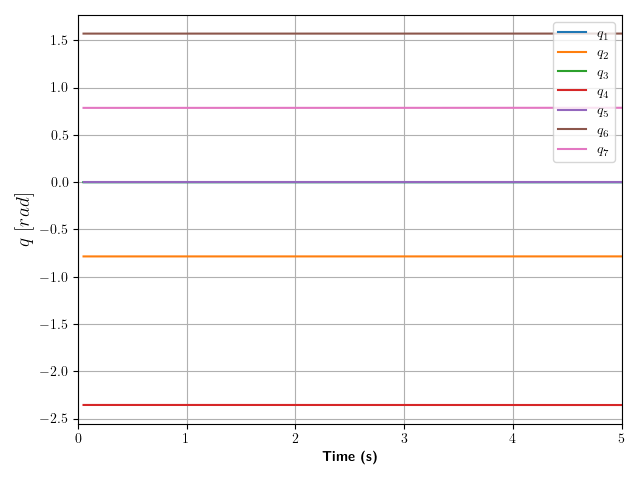

In [119]:
graphs_qs(t_list, q_list)

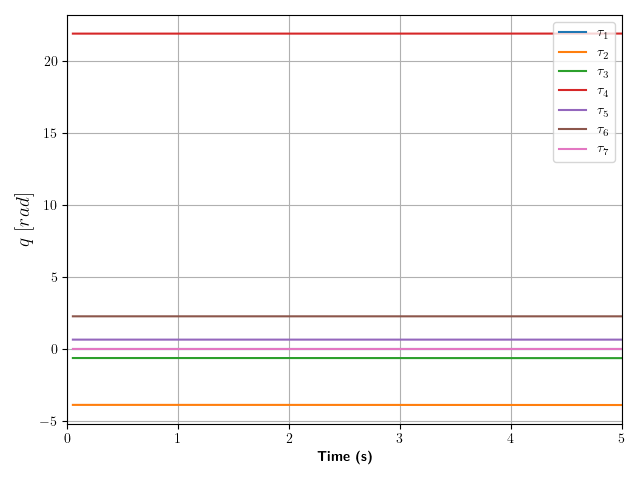

In [120]:
graphs_taus(t_list, u_list)

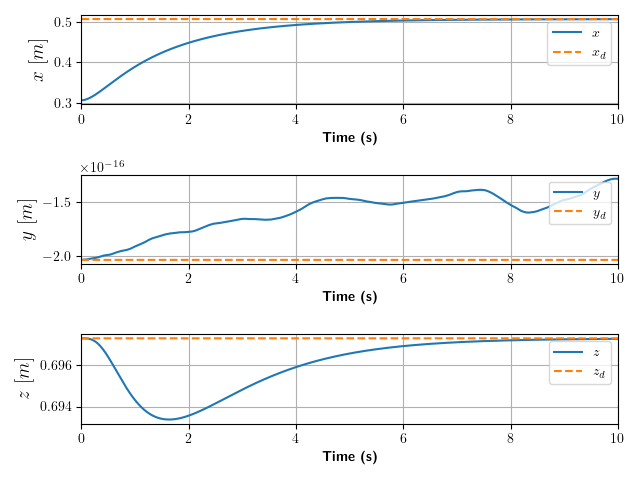

In [151]:
graphs_pose(t_list, pose_list, pose_des_list)

In [85]:
pin.forwardKinematics(model,data,q)
OMact =  data.oMi[jointIndex]    
oMdes = pin.SE3(OMact.rotation, np.array([OMact.translation[0], OMact.translation[1], OMact.translation[2]]))

q      = pin.neutral(model)
eps    = 1e-4
IT_MAX = 1000
DT     = 1e-1
damp   = 1e-12

i=0
while True:
    pin.forwardKinematics(model,data,q)
    iMd = data.oMi[jointIndex].actInv(oMdes)
    err = pin.log(iMd).vector  # in joint frame
    if norm(err) < eps:
        success = True
        break
    if i >= IT_MAX:
        success = False
        break
    J = pin.computeJointJacobian(model,data,q,jointIndex)  # in joint frame
    J = -np.dot(pin.Jlog6(iMd.inverse()), J)
    v = - J.T.dot(solve(J.dot(J.T) + damp * np.eye(6), err))
    q = pin.integrate(model,q,v*DT)
    if not i % 10:
        print('%d: error = %s' % (i, err.T))
    i += 1

if success:
    print("Convergence achieved!")
else:
    print("\nWarning: the iterative algorithm has not reached convergence to the desired precision")

print('\nresult: %s' % q.flatten().tolist())
print('\nfinal error: %s' % err.T)

0: error = [ 0.1591571  -0.74823859  0.13179041 -0.89932752 -0.2216371   1.56528424]
10: error = [ 0.07067174 -0.28113375  0.03330776 -0.36173858 -0.09225439  0.53752976]
20: error = [ 0.02612541 -0.09773395  0.01132498 -0.12608968 -0.03452098  0.1876035 ]
30: error = [ 0.00927478 -0.0340473   0.003921   -0.04395059 -0.01223112  0.06552039]
40: error = [ 0.00325245 -0.01186775  0.00136416 -0.01532132 -0.00428395  0.02286028]
50: error = [ 0.00113624 -0.00413755  0.0004753  -0.00534172 -0.00149589  0.00797272]
60: error = [ 0.00039645 -0.00144261  0.00016569 -0.00186248 -0.00052184  0.00278014]
70: error = [ 1.38263606e-04 -5.03000790e-04  5.77663268e-05 -6.49398471e-04
 -1.81985273e-04  9.69401396e-04]
80: error = [ 4.82133947e-05 -1.75384639e-04  2.01412605e-05 -2.26430269e-04
 -6.34580880e-05  3.38012682e-04]
90: error = [ 1.68114398e-05 -6.11527340e-05  7.02274892e-06 -7.89512341e-05
 -2.21269222e-05  1.17858138e-04]
Convergence achieved!

result: [0.47040566729336986, 1.07177586242